In [28]:
# Import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
from xgcm import Grid
# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")
# Set figure font size
plt.rcParams.update({'font.size':14})
import gfdl_utils as gu
import glob
from dask.diagnostics import ProgressBar

In [29]:
# Set up dask cluster
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(queue='stage7', cores=8, project='gfdl_o',
                       memory="128GB", walltime="01:30:00",
                       scheduler_options={"dashboard_address": f":{8726}"})

In [30]:
cluster.scale(1)

In [31]:
client = Client(cluster)
client

Client Scheduler: tcp://140.208.147.171:38199 Dashboard: http://140.208.147.171:8726/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [27]:
cluster.close()
client.close()

In [32]:
# Load data on native grid
pathDict = {'pp':('/archive/Raphael.Dussin/'+
                  'FMS2019.01.03_devgfdl_20210706/'+
                  'CM4_piControl_c192_OM4p125_v5/'+
                  'gfdl.ncrc4-intel18-prod-openmp/pp'),
           'ppname':'ocean_monthly_z_d2',
           'out':'av',
           'local':'monthly_5yr',
           'time':'*',
           'add':'*'}

path = gu.core.get_pathspp(**pathDict)
ds = gu.core.open_frompp(**pathDict)
gridpath = gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
grid = xr.open_dataset(gridpath).assign_coords({'xh':ds['xh'],'yh':ds['yh']})

# Specify the diffusive tendency terms
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':'opottemppmdiff',
         'frazil ice':'frazil_heat_tendency',
         'internal heat':'internal_heat_heat_tendency'}
# Specify the tracer range and bin widths (\delta\lambda) for the calculation
delta_l = 0.05
lmin = -3
lmax = 30
bins = np.arange(lmin,lmax,delta_l)
# Specify constants for the reference density and the specific heat capacity
rho0 = 1035.
Cp = 3992.

KeyboardInterrupt: 

In [4]:
G = xr.Dataset()
for process in processes:
    term = terms['heat'][process]
    nanmask = np.isnan(ds[term])
    G[process] = histogram(ds['thetao'].where(~nanmask).squeeze(),
                        bins=[bins],
                        dim=['xh','yh','z_l'],
                        block_size=len(ds['time']),
                        weights=(
                            rho0*(ds[term]/(Cp*rho0)
                                 )*grid['areacello']
                        ).where(~nanmask).squeeze()
                          )/np.diff(bins)

In [6]:
with ProgressBar():
    G = G.load()

[########################################] | 100% Completed |  1min 49.5s


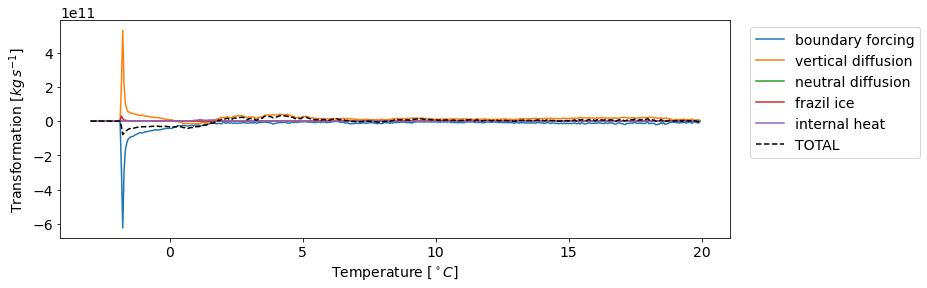

In [7]:
# Plot the time-mean transformation
fig, ax = plt.subplots(figsize=(12,4))
total = xr.zeros_like(G[processes[0]].mean('time'))
for process in processes:
    ax.plot(G['thetao_bin'],G[process].mean('time'),label=process)
    total += G[process].mean('time')
ax.plot(G['thetao_bin'],total,color='k',linestyle='--',label='TOTAL')
ax.legend(loc='upper left',bbox_to_anchor=(1.02,1))
ax.set_xlabel('Temperature [$^\circ C$]')
ax.set_ylabel('Transformation [$kg\,s^{-1}$]');

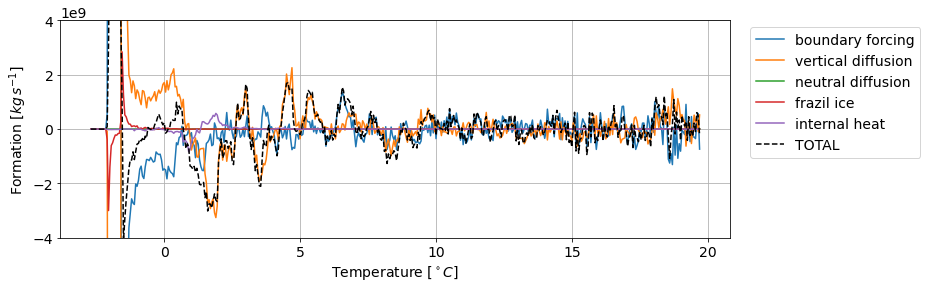

In [8]:
dG = -1*G.diff('thetao_bin')
# Plot the time-mean transformation
fig, ax = plt.subplots(figsize=(12,4))
total = xr.zeros_like(dG[processes[0]].mean('time'))
for process in processes:
    ax.plot(dG['thetao_bin'].rolling(thetao_bin=10,center=True).mean('thetao_bin'),dG[process].mean('time').rolling(thetao_bin=10,center=True).mean('thetao_bin'),label=process)
    total += dG[process].mean('time')
ax.plot(dG['thetao_bin'].rolling(thetao_bin=10,center=True).mean('thetao_bin'),total.rolling(thetao_bin=10,center=True).mean('thetao_bin'),color='k',linestyle='--',label='TOTAL')
ax.legend(loc='upper left',bbox_to_anchor=(1.02,1))
ax.set_xlabel('Temperature [$^\circ C$]')
ax.set_ylabel('Formation [$kg\,s^{-1}$]');
ax.set_ylim([-4e9,4e9]);
ax.grid()
fig.savefig('../figures/wmt_formation_thetao.png',dpi=300)

Check for budget closure

Text(0.5, 1.0, 'residual')

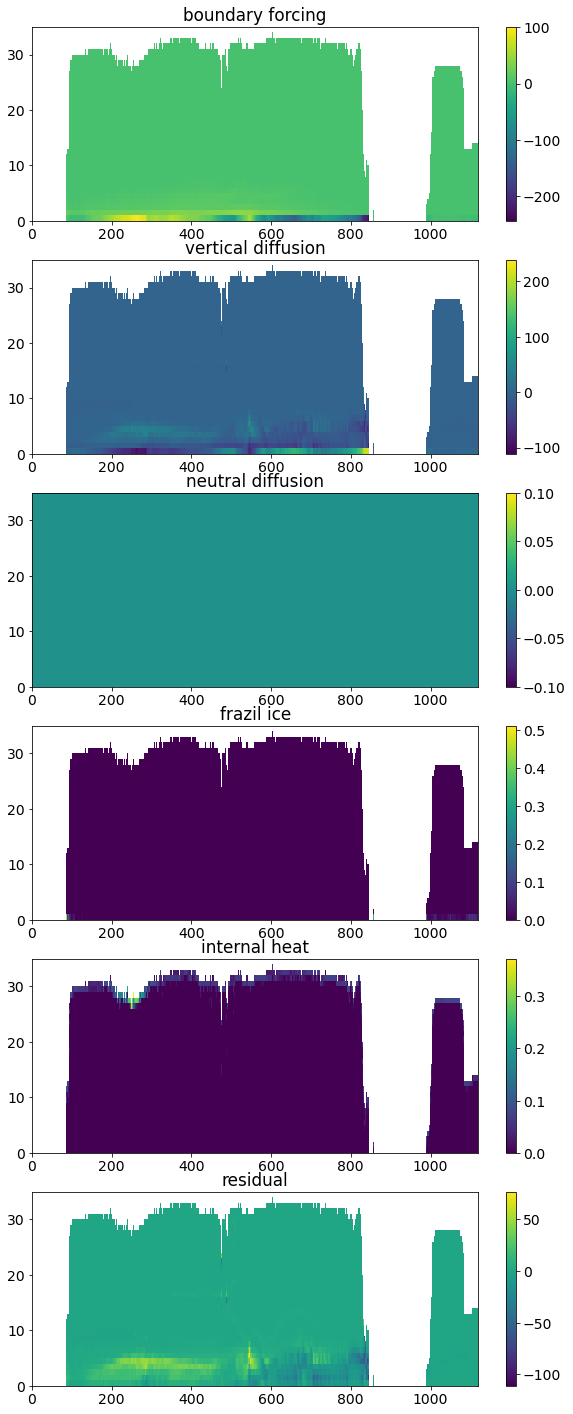

In [18]:
nt = len(terms['heat'])
iselect = {'xh':600,'time':0}
fig,axarr = plt.subplots(nrows=nt+1,figsize=(10,5*nt))
residual = xr.zeros_like(ds[terms['heat']['boundary forcing']])
for i,term in enumerate(terms['heat']):
    t = terms['heat'][term]
    ax = axarr.flat[i]
    da = ds[t]
    residual += da
    im = ax.pcolormesh(da.isel(**iselect))
    plt.colorbar(im,ax=ax)
    ax.set_title(term)
ax = axarr.flat[i+1]
da = residual
im = ax.pcolormesh(da.isel(**iselect))
plt.colorbar(im,ax=ax)
ax.set_title('residual')

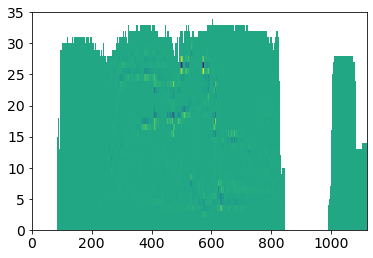

In [21]:
plt.pcolormesh(ds['opottemptend'].isel(**iselect))